<a href="https://colab.research.google.com/github/ariadna-guzman/E3-Deteccion-de-plagio-TC3002B.301/blob/main/Evidencia_2_Modelo_Mejorado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evidencia 2: Modelo Mejorado

- Ariadna Jocelyn Guzmán Jiménez A01749373
- Jorge Chávez Badillo A01749448
- Amy Murakami Tsutsumi A01750185


## Instalación de Librerías

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip -q install sentencepiece

In [ ]:
!pip -q install langdetect

In [ ]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importación de Librerías

In [ ]:
# Herramienta de lenguaje natural
import torch
import nltk
nltk.download("wordnet")
nltk.download("omw-1.4")
from nltk.stem import WordNetLemmatizer
import re
# Para el cálculo de la distancia entre párrafos
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
# Para la manipulación y lectura de archivos
import os
import matplotlib.pyplot as plt
# Para la obtención de métricas de los modelos
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
# Para la visualización, análisis y manipulación de los datos 
import pandas as pd
from tqdm import tqdm 
# Para la creación de vectores y matrices
import numpy as np
from keras_preprocessing.sequence import pad_sequences
# Implementación de BERT
from transformers import BertTokenizer, AutoModelForSequenceClassification
# Para la traducción de textos
from transformers import MarianMTModel, MarianTokenizer
from langdetect import detect, DetectorFactory

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Importación de Textos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
genuinos = '/content/drive/Shareddrives/Desarrollo de Aplicaciones Avanzadas de Ciencias Computacionales/Reto/Evidencia 2/2023-Datasets/Etapa1/documentos-genuinos/'
sospechosos = '/content/drive/Shareddrives/Desarrollo de Aplicaciones Avanzadas de Ciencias Computacionales/Reto/Evidencia 2/2023-Datasets/Etapa1/docmentos-sospechosos/'

### Funciones para el Preprocesamiento de Datos

In [ ]:
def clean_data(text):
  '''
  Función para eliminar caractertes especiales del texto.
  '''
  clean_text = re.sub(r'[^\w\s]', '', text)
  clean_text = re.sub(r'\n|\,|\.|\;', '', text)
  return clean_text

In [ ]:
def lemm_parrafo(text):
  '''  
  Función para aplicar lematización en los párrafos.
  '''  
  text = clean_data(text)
  lemmatizer = WordNetLemmatizer()
  parrafo_lemm = []

  for palabra in text.split(' '): 
    palabra_lemm = lemmatizer.lemmatize(palabra)
    parrafo_lemm.append(palabra_lemm)

  parrafo_str = ' '.join(parrafo_lemm)
  return parrafo_str

In [ ]:
def create_frame(path):
  '''
  Función que crea el dataframe que contiene el nombre del archivo 
  y contenido para la carpeta de archivos (path) seleccionada.
  '''
  content = []
  names = []
  files_list = sorted(os.listdir(path))
  for file_name in files_list:
    with open(path + file_name, 'r') as file:
      data = file.read().rstrip()
      content.append(lemm_parrafo(data))
      names.append(file_name)
  dictionary = {'name': names, 'content': content}
  df = pd.DataFrame(dictionary)
  return df

### Creación del Data Frame de Archivos Genuinos

Se muestran los primeros cinco documentos de la carpeta de documentos genuinos en el dataframe.

In [ ]:
df_genuinos = create_frame(genuinos)
df_genuinos.head(5)

,name,content
0,org-300.txt,Automatic software plagiarism detection tool a...
1,org-301.txt,A casual comment by a student alerted the auth...
2,org-302.txt,Paraphrase type have been proposed by research...
3,org-303.txt,This paper address the issue of text matching ...
4,org-304.txt,This work present a Sentence Hashing Algorithm...


## Implementación de Bert

*(Bidirectional Encoder Representations From Transformers)*

In [ ]:
model_name = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case = True)

model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           output_attentions = False,
                                                           output_hidden_states = True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

### Vectorización

#### Por texto

In [ ]:
def vectorize_text(tokenizer, model, abstract, MAX_LEN = 510):
  '''
  Función que genera la representación vectorial de un documento.
  Recibe como parámetros el tokenizer, el modelo, el documento y 
  el número máximo de tokens. 
  '''
  inputs = tokenizer.encode(abstract, 
                            add_special_tokens = True, 
                            max_length = MAX_LEN,)    

  results = pad_sequences([inputs], 
                          maxlen=MAX_LEN, 
                          dtype="long", 
                          truncating="post", 
                          padding="post")
  inputs = results[0] # Eliminar lista exterior

  # Máscaras
  ''' for i in inputs:
    mask = int(i>0)'''
  mask = [int(i > 0) for i in inputs]

  # Tensores
  inputs = torch.tensor(inputs)
  mask = torch.tensor(mask)

  # Dimensión adicional para batch
  inputs = inputs.unsqueeze(0)
  mask = mask.unsqueeze(0)

  # Evaluación de modelo
  model.eval()

  # Recopílación de estado a través de BERT
  with torch.no_grad():        
        logits, encoded_layers = model(input_ids = inputs, 
                                        token_type_ids = None, 
                                        attention_mask = mask,
                                        return_dict = False)

  layer_i = 12 # Última capa BERT antes de clasificación
  batch_i = 0 # Entrada del batch
  token_i = 0 # Primer token

  # Extraer el vector
  vector = encoded_layers[layer_i][batch_i][token_i]

  # Numpy array
  vector = vector.detach().cpu().numpy()

  return vector

#### Base de Datos

In [ ]:
def vectorize_database(data):
  '''
  Función que genera una base de datos que contiene los vectores
  de todos los documentos. 
  '''
  vectors = []

  # Obtención de datos generales del contenido
  source = data.content.values

  # Recorrer texto para la obtención de los embeddings
  for content in tqdm(source):
    # Obtener el embedding
    vector = vectorize_text(tokenizer, model, content)
    vectors.append(vector)
  
  data['vectors'] = vectors
  data['vectors'] = data['vectors'].apply(lambda emb: np.array(emb))
  data['vectors'] = data['vectors'].apply(lambda emb: emb.reshape(1, -1))
  return data

### Creación de Vector para los Archivos Genuinos

In [ ]:
vector_genuinos = vectorize_database(df_genuinos)

100%|██████████| 120/120 [04:43<00:00,  2.37s/it]


In [ ]:
vector_genuinos.head()

,name,content,vectors
0,org-300.txt,Automatic software plagiarism detection tool a...,"[[-0.7122702, 0.34844428, -0.13587844, -0.0483..."
1,org-301.txt,A casual comment by a student alerted the auth...,"[[-0.859755, 0.11560044, -0.6182534, 0.1916422..."
2,org-302.txt,Paraphrase type have been proposed by research...,"[[-0.8693308, 0.1778697, -0.57536095, -0.31688..."
3,org-303.txt,This paper address the issue of text matching ...,"[[-0.8720792, 0.034670662, -0.55668145, 0.1511..."
4,org-304.txt,This work present a Sentence Hashing Algorithm...,"[[-0.6819566, -0.053224877, 0.27515307, -0.224..."


## Funciones para la Detección de Plagio

In [ ]:
def vectorize_cosine(sus_text):
  '''
  Función que crea un vector de acuerdo al texto de entrada 
  para ajustarlo para calcular la similitud de coseno.
  '''
  
  sus_vect = vectorize_text(tokenizer, model, sus_text)
  sus_vect = np.array(sus_vect)
  sus_vect = sus_vect.reshape(1, -1)
  return sus_vect

In [ ]:
def detect_plagiarism(score, threshold):
  '''
  Función que determina si el texto es plagio o no de acuerdo 
  a un cierto umbral.
  '''

  status = 0

  if(score >= threshold):
    status = 1
  
  return status 

In [ ]:
def plagiarism_analysis(sus_name, sus_text, database_vector, threshold):
  '''
  Función que regresa los resultados de la detección de plagio, señalando
  los archivos comparados y el nivel de similitud obtenido.
  '''

  sus_vect = vectorize_cosine(sus_text)

  # Similitud Coseno
  database_vector['similarity'] = database_vector['vectors'].apply(
      lambda x: cosine_similarity(sus_vect, x))
  database_vector['similarity'] = database_vector['similarity'].apply(
      lambda x: x[0][0])
  
 # Top 5 Archivos similares  
  similar_files = database_vector.sort_values(by = 'similarity', 
                                              ascending = False)[0:4]
  df_result = similar_files[['name', 
                             'content', 
                             'similarity']].reset_index(drop = True)
  
  similarity_score = df_result.iloc[0]['similarity']
  most_similar_f_name = df_result.iloc[0]['name']
  most_similar_f_content = df_result.iloc[0]['content']
  status = detect_plagiarism(similarity_score, threshold)


  plagiarism_analysis = [sus_name, 
                         most_similar_f_name,
                         status,
                         similarity_score,
                         most_similar_f_content,
                         sus_text]

  return plagiarism_analysis

## Detección de Plagio

In [ ]:
df_sus = create_frame(sospechosos)
df_sus.head()

,name,content
0,FID-01.txt,This systematic review provides unique finding...
1,FID-02.txt,In this review we describe the application of ...
2,FID-03.txt,How to measure similarity between two sequence...
3,FID-04.txt,Text similarity measurement is the basis of na...
4,FID-05.txt,Hoy en día el idioma ha dejado de ser una barr...


In [ ]:
df_sus.iloc[3]

name                                              FID-04.txt
content    Text similarity measurement is the basis of na...
Name: 3, dtype: object

In [ ]:
'''
Vector con los valores reales de los archivos sospechosos (1, 0)
  1: Archivos Plagio
  0: Archivos Genuinos
'''
name_sos = sorted(os.listdir(sospechosos))
true_labels = []

for i in name_sos:
  if int(i[4:6]) % 2 == 0:
    true_labels.append(0)
  else:
    true_labels.append(1)
prediction_values = []
prediction_score = []

def sus_analysis(path_sus):
  '''
  Función que compara todos los archivos genuinos con todos los archivos 
  sospechosos. Muestra el archivo sospechoso, el estado, la similitud y 
  el archivo que tiene mayor similitud.
  '''
  df_sus = create_frame(path_sus)

  for row in range(len(df_sus)):
    name_sus = df_sus.iloc[row]['name']
    content_sus = df_sus.iloc[row]['content']
    analysis = plagiarism_analysis(name_sus, content_sus, vector_genuinos, 0.93)
    print("="*30)
    print('Nombre del archivo sospechoso:', analysis[0])
    print('Nombre del archivo genuino similar:', analysis[1])
    print('Status:', analysis[2])
    print('Score de similitud:', analysis[3])
    prediction_values.append(analysis[2])
    prediction_score.append(analysis[3])
  return

In [ ]:
sus_analysis(sospechosos)

Nombre del archivo sospechoso: FID-01.txt
Nombre del archivo genuino similar: org-325.txt
Status: 1
Score de similitud: 0.9951241
Nombre del archivo sospechoso: FID-02.txt
Nombre del archivo genuino similar: org-402.txt
Status: 0
Score de similitud: 0.92035645
Nombre del archivo sospechoso: FID-03.txt
Nombre del archivo genuino similar: org-306.txt
Status: 0
Score de similitud: 0.91379523
Nombre del archivo sospechoso: FID-04.txt
Nombre del archivo genuino similar: org-339.txt
Status: 0
Score de similitud: 0.9133811
Nombre del archivo sospechoso: FID-05.txt
Nombre del archivo genuino similar: org-340.txt
Status: 1
Score de similitud: 0.9728546
Nombre del archivo sospechoso: FID-06.txt
Nombre del archivo genuino similar: org-339.txt
Status: 1
Score de similitud: 0.9411098
Nombre del archivo sospechoso: FID-07.txt
Nombre del archivo genuino similar: org-418.txt
Status: 1
Score de similitud: 0.93230796
Nombre del archivo sospechoso: FID-08.txt
Nombre del archivo genuino similar: org-351.t

In [ ]:
print(prediction_values)

[1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1]


In [ ]:
print('Accuracy Score: {:.4f}'.format(accuracy_score(true_labels, prediction_values)))

Accuracy Score: 0.8667


## Métricas del Modelo

In [ ]:
def metricas(true_labels, prediction_values):
  '''
  Función para obtener las métricas del modelo a partir de
  la matriz de confusión
  '''
  cf_mat = confusion_matrix(true_labels, prediction_values)
  precision = cf_mat[0][0] / (cf_mat[0][0] + cf_mat[0][1])
  recall = cf_mat[0][0] / (cf_mat[0][0] + cf_mat[1][0])
  specificity = cf_mat[1][1] / (cf_mat[1][1] + cf_mat[0][1])

  print('Precision: {:.4f}'.format(precision))
  print('Recall: {:.4f}'.format(recall))
  print('Specificity: {:.4f}'.format(specificity))
  print('Accuracy Score: {:.4f}'.format(accuracy_score(true_labels, 
                                                       prediction_values)))
  print('F1 Score : {:.4f}'.format(f1_score(true_labels, 
                                                 prediction_values)))
  print('Confusion Matrix:')
  print(cf_mat)

  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_mat, display_labels = [False, True])
  cm_display.plot()
  plt.show() 

In [ ]:
def plot_roc_curve(true_y, y_prob):
    '''
    Función para gráficar la AUC-ROC
    '''
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

Precision: 0.8571
Recall: 0.8571
Specificity: 0.8750
Accuracy Score: 0.8667
F1 Score : 0.8750
Confusion Matrix:
[[6 1]
 [1 7]]


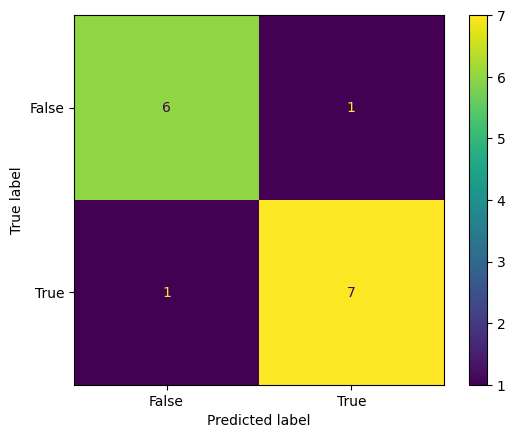

In [ ]:
metricas(true_labels, prediction_values)

### AUC-ROC Curve

AUC score: 0.8661


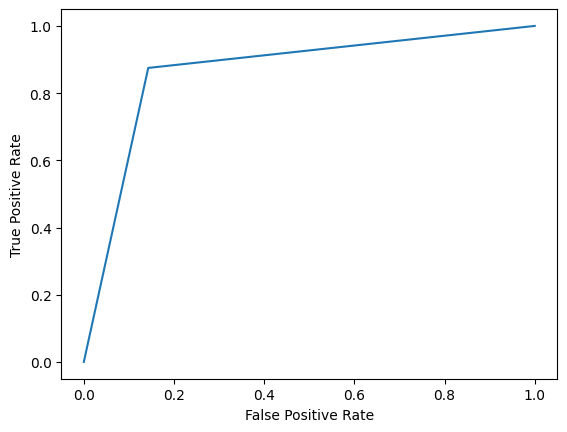

In [ ]:
plot_roc_curve(true_labels, prediction_values)
print('AUC score: {:.4f}'.format(roc_auc_score(true_labels, prediction_values)))

## Conclusiones

En conclusión, el análisis de detección de plagio utilizando la lematización y BERT en Python es una estrategia más efectiva para identificar similitudes y posibles casos de plagio en documentos o textos. La lematización permite reducir las palabras a su forma base, lo que ayuda a agrupar términos similares y minimizar las variaciones léxicas. Por otro lado, BERT es un modelo de lenguaje pre entrenado que captura el contexto y las relaciones semánticas entre las palabras.

A comparación de la evidencia 1,el combinar la lematización con BERT este entregable marcó una diferencia significativa, ya que se logró un enfoque más preciso para detectar el plagio gracias a una comprensión más profunda del significado de las palabras y las estructuras gramaticales. Esto permite identificar similitudes incluso si las palabras han sido modificadas o reorganizadas en cierta medida.

Finalmente, dada nuestra implementación, se considera como plan a futuro poder agregar más funciones que aporten a nuestro modelo mayor valor agregado. Por ejemplo, considerar la librería de Python langdetect para poder detectar el plagio en textos traducidos, considerando que este también es un tipo de plagio que se encuentra comúnmente.